Use the initial condition prescribed in example here: http://databookuw.com/databook.pdf#page=93

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf

In [2]:
# plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
# plt.rc("text", usetex=True)

In [3]:
# Construct the spatial domain.
L = 1                           # Spatial domain length.
n = 2**7 - 1                    # Spatial grid size.
x_all = np.linspace(0, L, n+2)  # Full spatial grid.
x = x_all[1:-1]                 # Interior spatial grid (where q is unknown).
dx = x[1] - x[0]                # Spatial resolution.

# Construct the temporal domain.
T = 1                           # Temporal domain length (final simulation time).
K = T*10**3 + 1                 # Temporal grid size.
t = np.linspace(0, T, K)        # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

print(f"Spatial step size δx = {dx}")
print(f"Temporal step size δt = {dt}")

Spatial step size δx = 0.0078125
Temporal step size δt = 0.001


In [4]:
x_all.shape

(129,)

In [5]:
# Construct the full-order state matrix A.
dx2inv = 1 / dx**2
diags = np.array([1, -2, 1]) * dx2inv
A = sparse.diags(diags, [-1, 0, 1], (n, n))

In [6]:
alpha = 100

wave_lb = np.floor((L/2 - L/8)/dx).astype(int)
wave_ub = np.floor((L/2 + L/8)/dx).astype(int)

print("Index for Wave Begin and End is {}, {}".format(wave_lb, wave_ub))

q0 = np.zeros(x.shape)
q0[wave_lb:wave_ub] = 1

Index for Wave Begin and End is 48, 80


In [7]:
def implicit_euler(t, q0, A):
    """Solve the system

        dq / dt = Aq(t),    q(0) = q0,

    over a uniform time domain via the implicit Euler method.

    Parameters
    ----------
    t : (k,) ndarray
        Uniform time array over which to solve the ODE.
    q0 : (n,) ndarray
        Initial condition.
    A : (n, n) ndarray
        State matrix.

    Returns
    -------
    q : (n, k) ndarray
        Solution to the ODE at time t; that is, q[:,j] is the
        computed solution corresponding to time t[j].
    """
    # Check and store dimensions.
    k = len(t)
    n = len(q0)

    assert A.shape == (n, n)

    I = np.eye(n)

    # Check that the time step is uniform.
    dt = t[1] - t[0]
    assert np.allclose(np.diff(t), dt)

    # Factor I - dt*A for quick solving at each time step.
    factored = la.lu_factor(I - dt*A)

    # Solve the problem by stepping in time.
    q = np.empty((n, k))
    q[:,0] = q0.copy()
    for j in range(1, k):
        q[:, j] = la.lu_solve(factored, q[:, j-1])

    return q

In [8]:
Q_all = implicit_euler(t, q0, A)
Q_all.shape

(127, 1001)

In [9]:
# Retain only the first k snapshots/inputs for training the ROM.
k = 100                         # Number of training snapshots.
t_train = t[:k]                 # Temporal domain for training snapshots.
Q = Q_all[:, :k]                # Observed snapshots.

In [10]:
# Estimate time derivatives (dq/dt) for each training snapshot.
Qdot_train = (Q[:, 1:] - Q[:, :-1]) / dt
Q_train = Q[:, 1:]              # Training snapshots.

print(f"shape of Q_train:\t{Q_train.shape}")
print(f"shape of Qdot_train:\t{Qdot_train.shape}")

shape of Q_train:	(127, 99)
shape of Qdot_train:	(127, 99)


In [11]:
def plot_heat_data(Z, title, ax=None):
    """Visualize temperature data in space and time."""
    if ax is None:
        _, ax = plt.subplots(1, 1)

    # Plot a few snapshots over the spatial domain.
    sample_columns = [0, 10, 20, 40, 80, 160, 320, 640]
    sample_columns = [0] + [2**d for d in range(10)]
    color = iter(plt.cm.viridis_r(np.linspace(.05, 1, len(sample_columns))))
    while sample_columns[-1] > Z.shape[1]:
        sample_columns.pop()
    leftBC, rightBC = [0], [0]
    for j in sample_columns:
        q_all = np.concatenate([leftBC, Z[:,j], rightBC])
        ax.plot(x_all, q_all, color=next(color), label=fr"$q(x,t_{{{j}}})$")

    ax.set_xlim(x_all[0], x_all[-1])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$q(x,t)$")
    ax.legend(loc=(1.05, .05))
    ax.set_title(title)

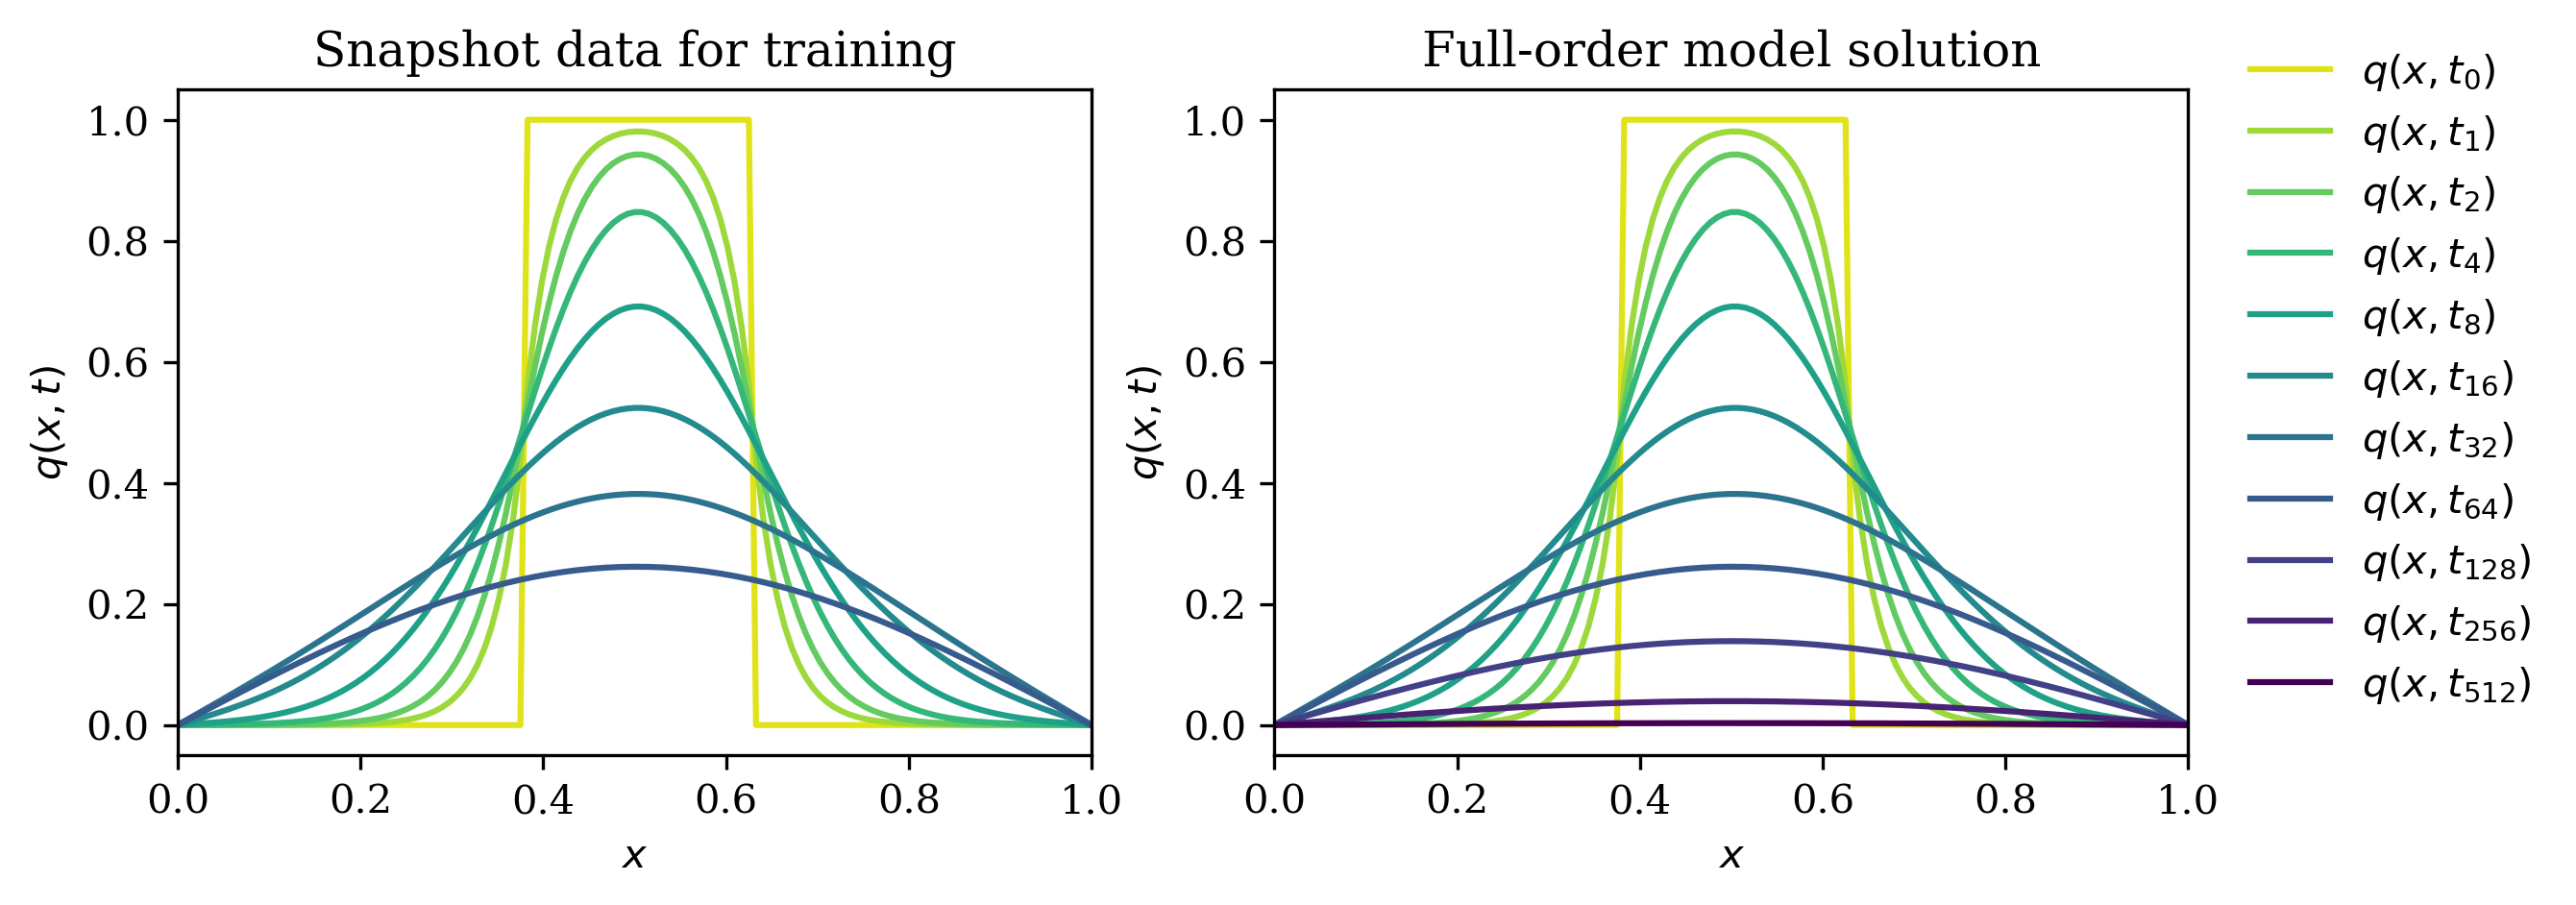

In [12]:
fig, [ax1, ax2] = plt.subplots(1, 2)
plot_heat_data(Q, "Snapshot data for training", ax1)
plot_heat_data(Q_all, "Full-order model solution", ax2)
ax1.legend([])
plt.show()

PODBasis
Full-order dimension    n = 127
Reduced-order dimension r = 8


(0.0, 25.0)

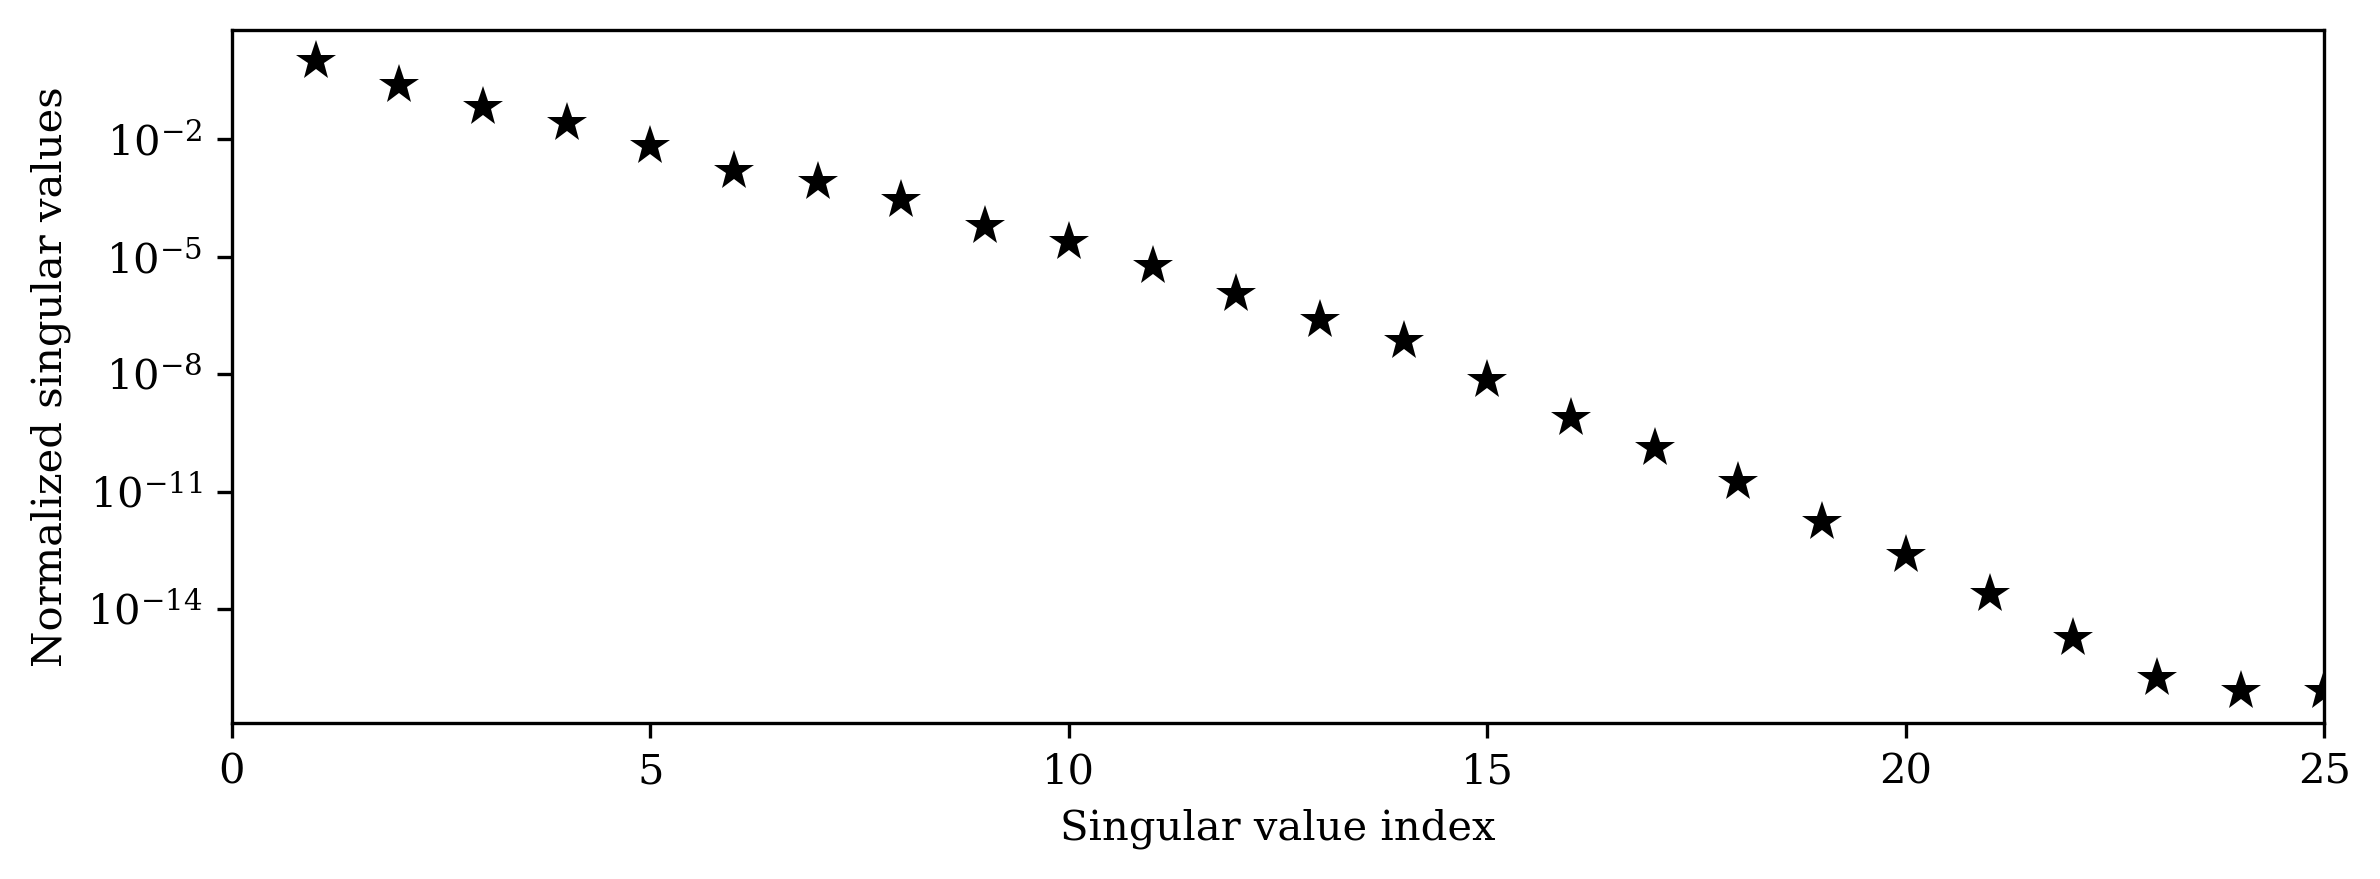

In [13]:
# Compute the POD basis, using the residual energy decay to select r.
basis = opinf.pre.PODBasis().fit(Q, residual_energy=1e-8)
print(basis)

# Check the decay of the singular values.
basis.plot_svdval_decay()
plt.xlim(0, 25)

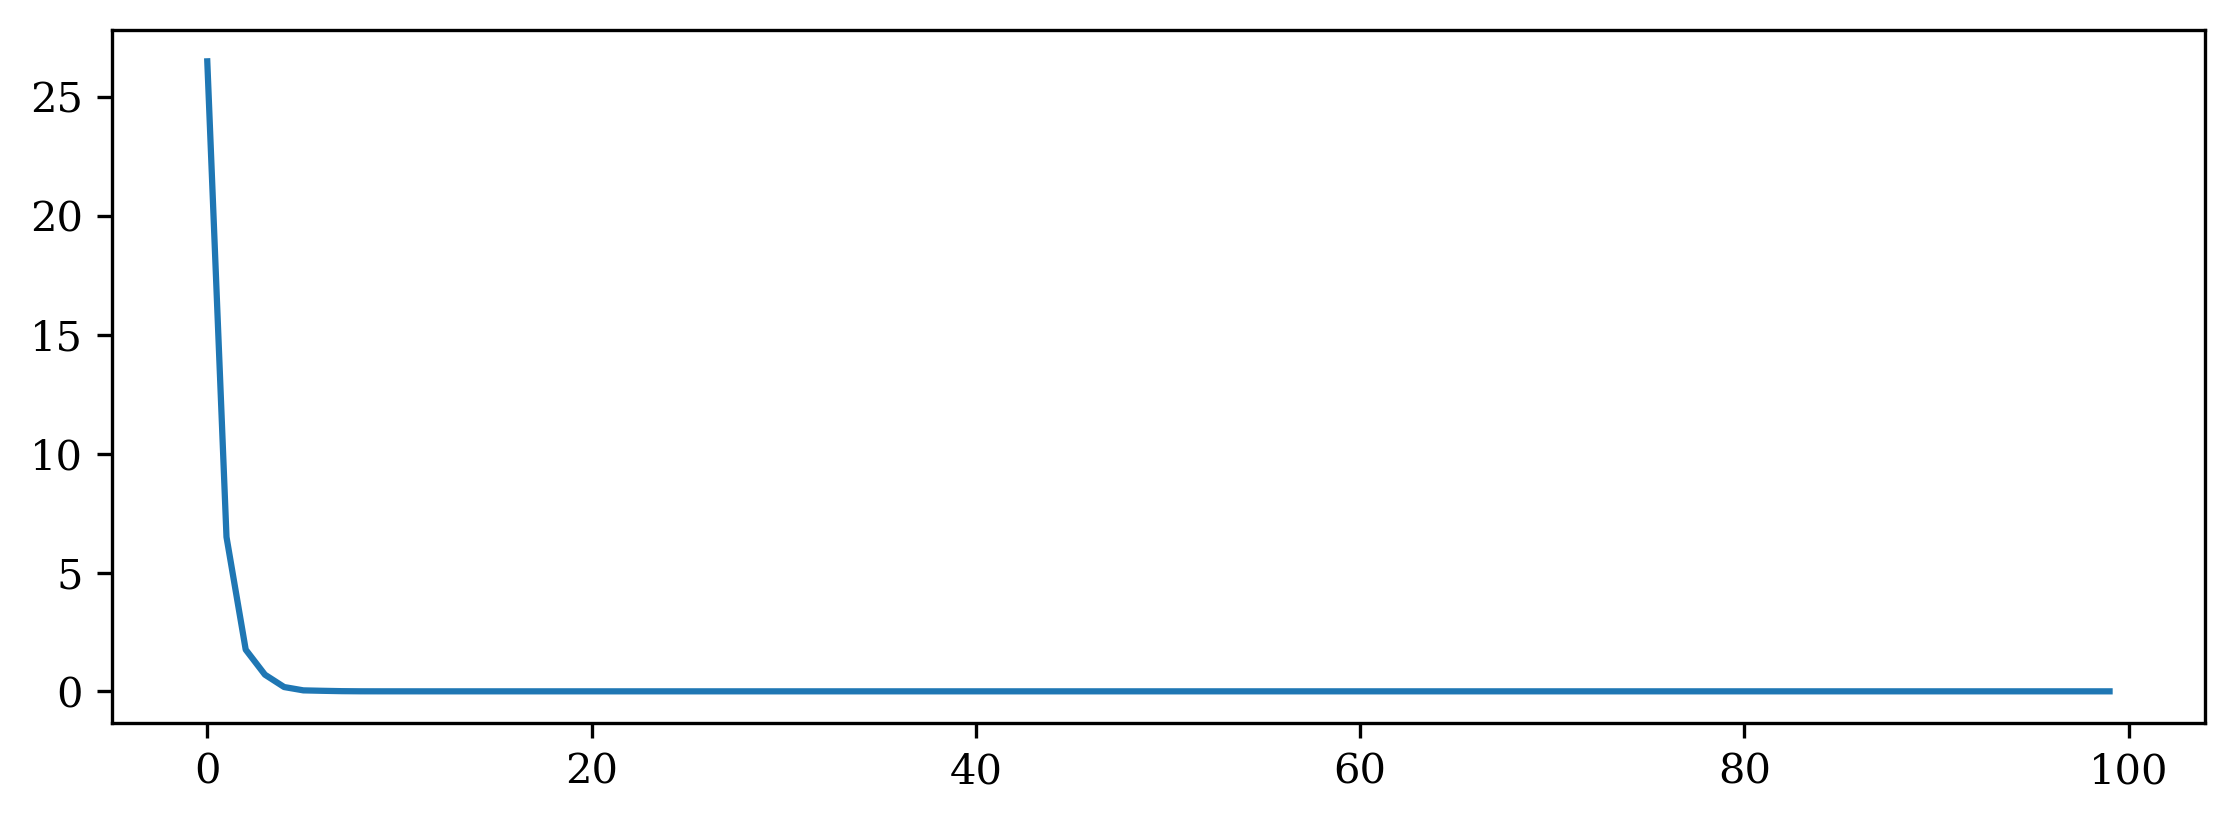

In [14]:
plt.plot(basis.svdvals)

In [15]:
rom = opinf.ContinuousOpInfROM(modelform="A")

In [16]:
rom.fit(basis=basis, states=Q_train, ddts=Qdot_train)

Reduced-order model structure: dq / dt = Aq(t)
Full-order dimension    n = 127
Reduced-order dimension r = 8

In [17]:
# Express the initial condition in the coordinates of the basis.
q0_ = basis.encode(q0)

# Solve the reduced-order model using Implicit Euler.
Q_ROM = basis.decode(implicit_euler(t, q0_, rom.A_.entries))

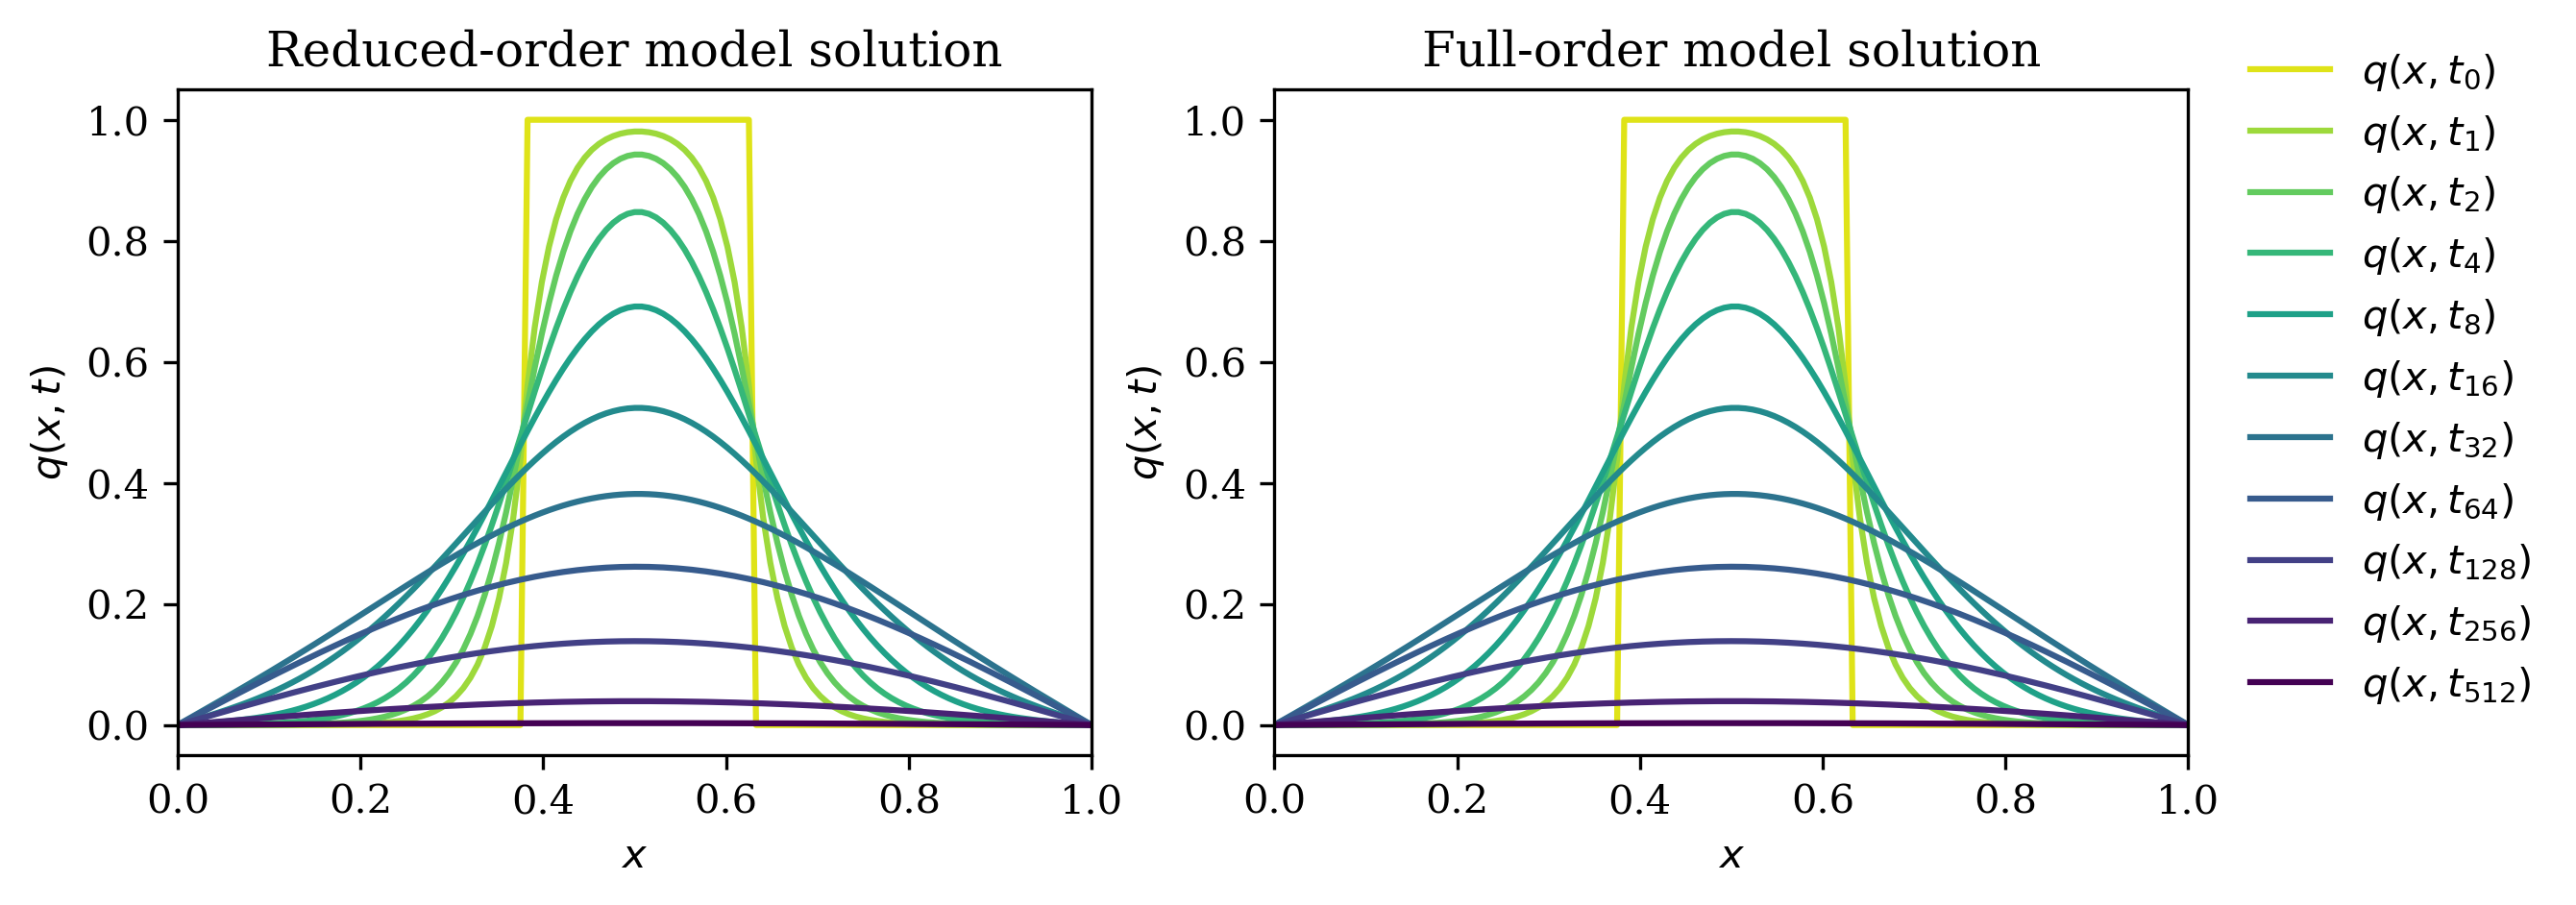

In [18]:
fig, [ax1, ax2] = plt.subplots(1, 2)
plot_heat_data(Q_ROM, "Reduced-order model solution", ax1)
plot_heat_data(Q_all, "Full-order model solution", ax2)
ax1.legend([])
plt.show()

Plot entries of learnt ROM operator $A$ as a heatmap

In [19]:
A_learnt = rom.A_.entries

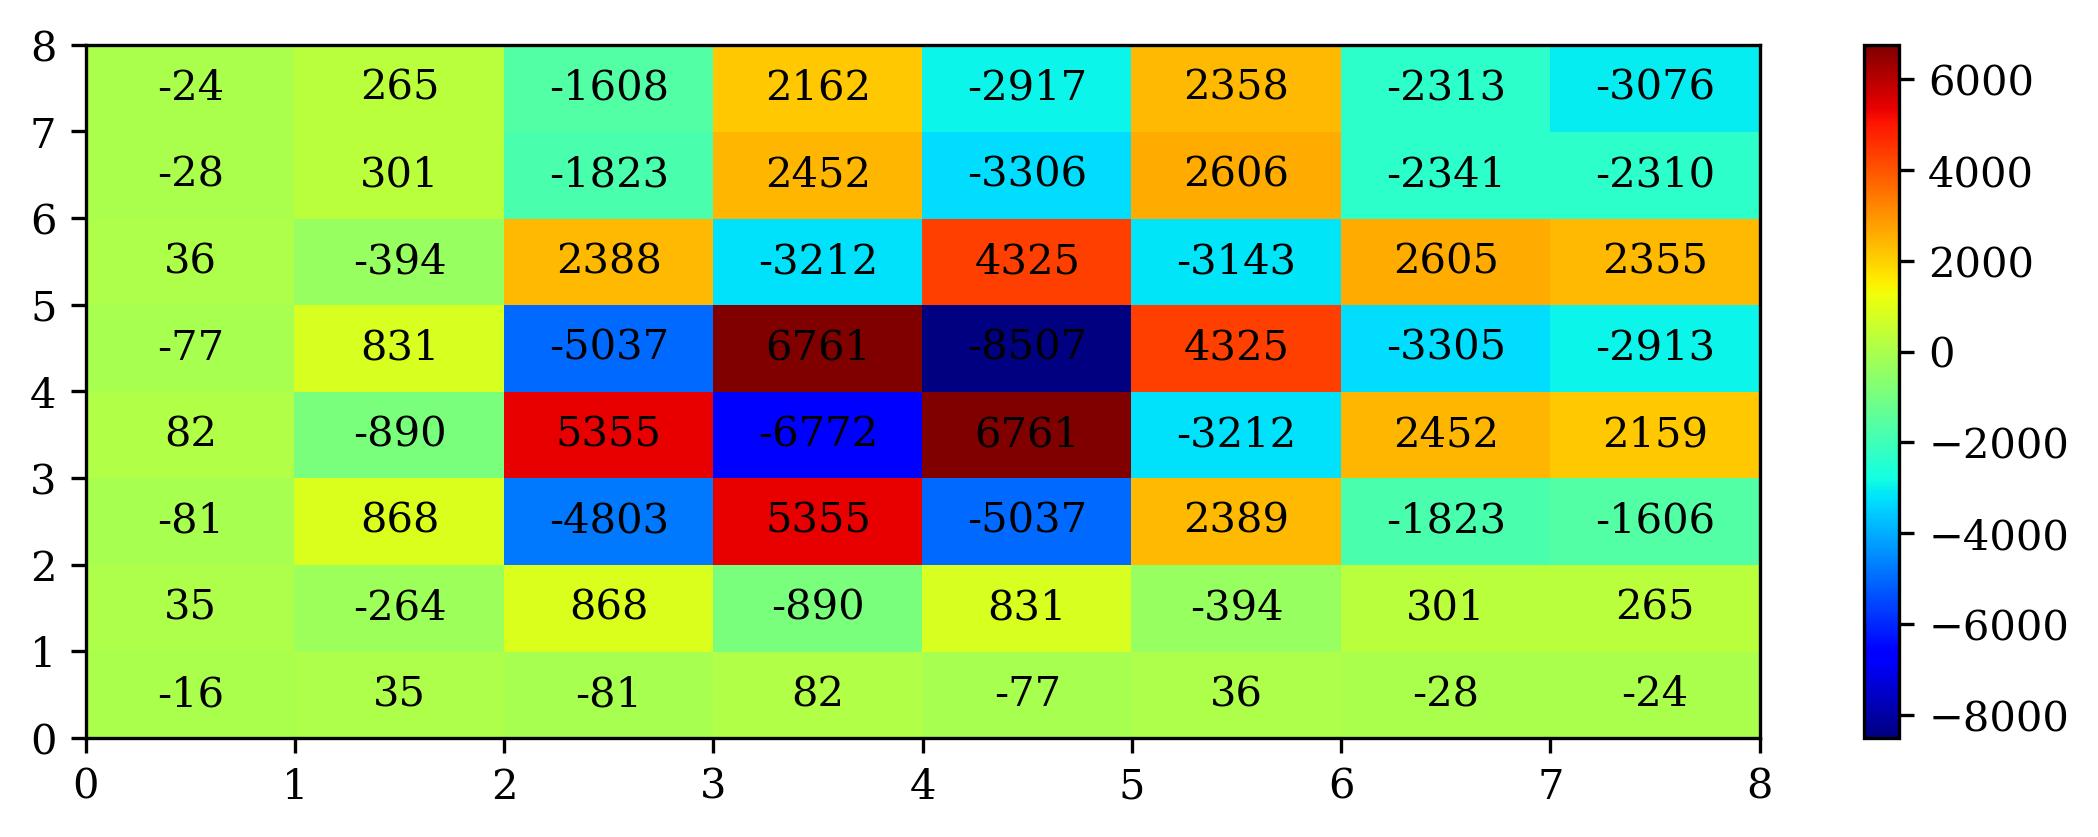

In [20]:
hmAhat = plt.pcolor(A_learnt, cmap='jet')

for y in range(A_learnt.shape[0]):
    for x in range(A_learnt.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%2.0f' % A_learnt[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

plt.colorbar(hmAhat)

Plot entries of original operator in the same way.

In [21]:
A_orig = np.array(A.todense()[5:10, 5:10]) * dx**2
A_orig

array([[-2.,  1.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  1., -2.]])

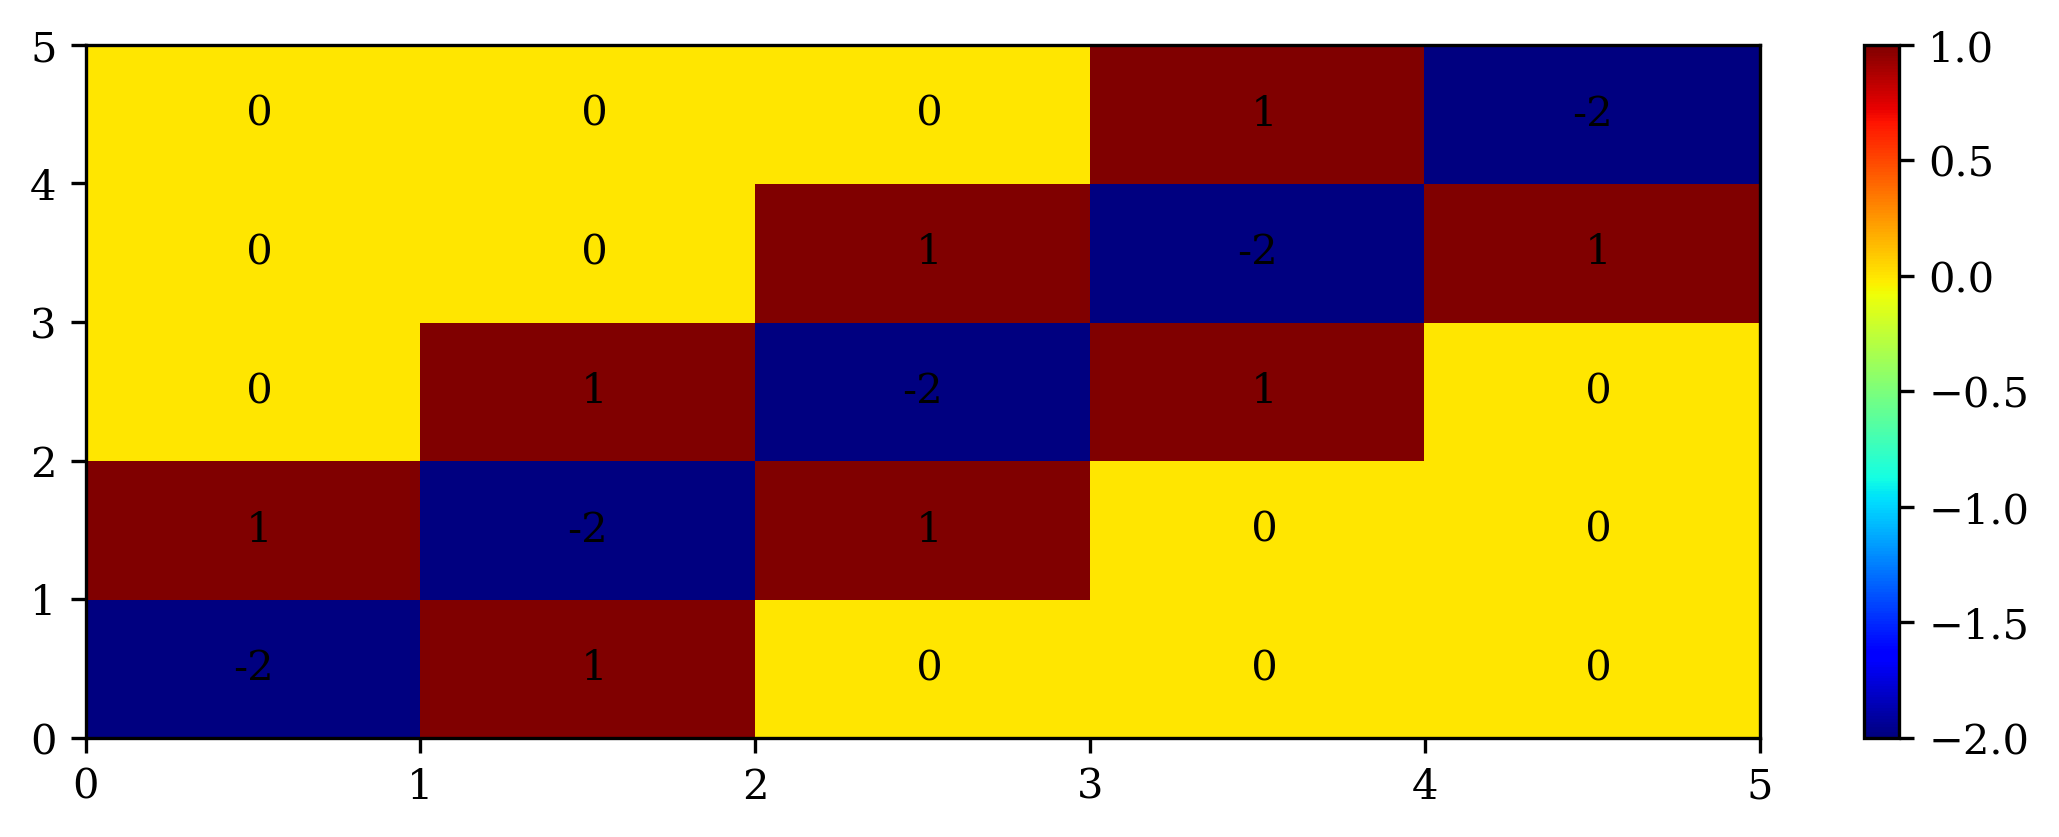

In [22]:
hmAorig = plt.pcolor(A_orig, cmap='jet')

for y in range(A_orig.shape[0]):
    for x in range(A_orig.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%2.0f' % A_orig[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

plt.colorbar(hmAorig)

In [23]:
rel_froerr_projection = basis.projection_error(Q_all, relative=True)
rel_froerr_opinf = opinf.post.frobenius_error(Q_all, Q_ROM)[1]

print("Relative Frobenius-norm errors", '-'*33,
      f"projection error:\t{rel_froerr_projection:%}",
      f"OpInf ROM error:\t{rel_froerr_opinf:%}",
      sep='\n')

Relative Frobenius-norm errors
---------------------------------
projection error:	0.008367%
OpInf ROM error:	0.008817%


Get the test errors, and plot relative error as a function of time.

`normalize=True` ensures that relative error denom is replaced by maximum of QoI. Since otherwise it approaches zero as we go forward in time

In [24]:
projerr_in_time = opinf.post.lp_error(Q_all,
                                      basis.project(Q_all),
                                      normalize=True)[1]

def plot_errors_over_time(Zlist, labels):
    """Plot normalized absolute projection error and ROM errors
    as a function of time.

    Parameters
    ----------
    Zlist : list((n, k) ndarrays)
        List of reduced-order model solutions.
    labels : list(str)
        Labels for each of the reduced-order models.
    """
    fig, ax = plt.subplots(1, 1)
    
    ax.semilogy(t, projerr_in_time, "C3", label="Projection Error")
    colors = ["C0", "C5"]
    for Z, label, c in zip(Zlist, labels, colors[:len(Zlist)]):
        rel_err = opinf.post.lp_error(Q_all, Z, normalize=True)[1]
        plt.semilogy(t, rel_err, c, label=label)

    ax.set_xlim(t[0], t[-1])
    ax.set_xlabel(r"$t$")
    ax.set_ylabel("Normalized absolute error")
    ax.legend(loc="lower right")
    plt.show()

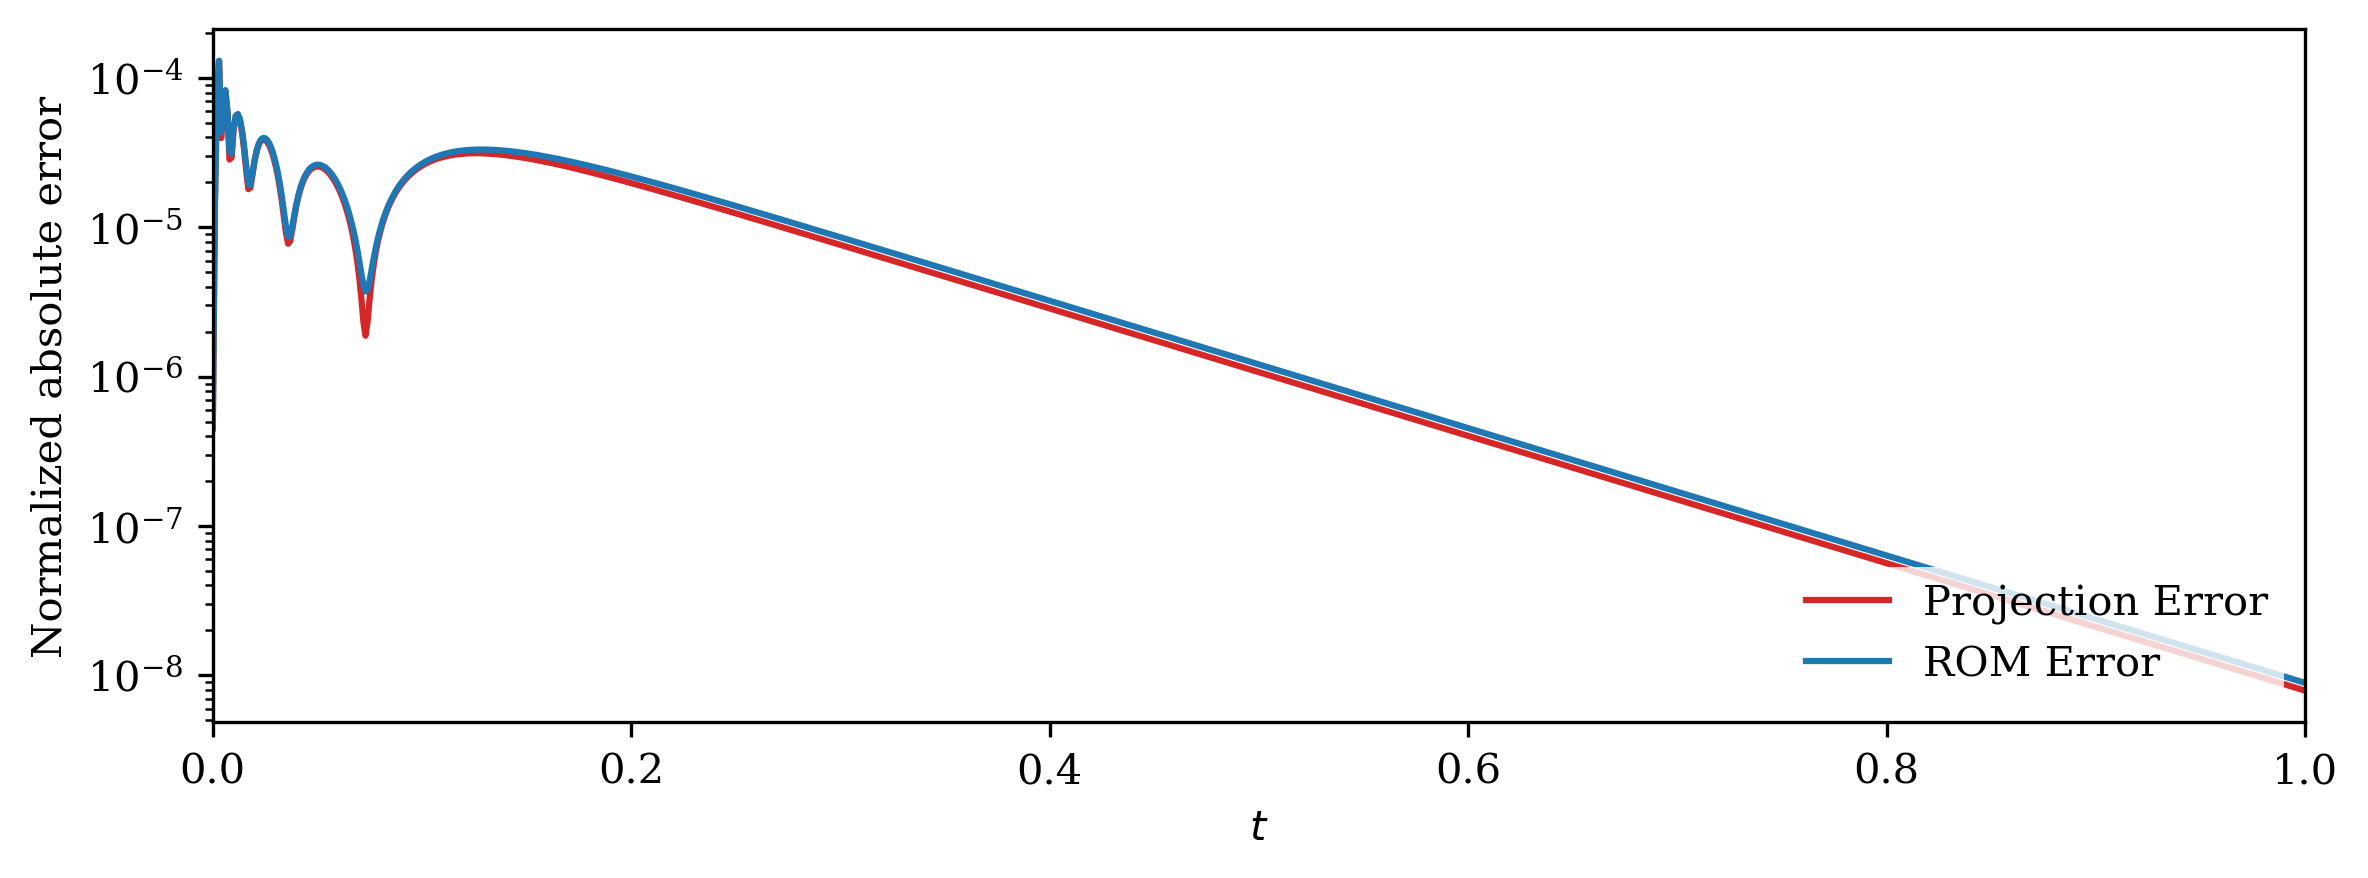

In [25]:
plot_errors_over_time([Q_ROM], ["ROM Error"])

Error drops by 4 orders of magnitude over the time from 0.2 to 1 second! (not the case for the tutorial problem where it more or less stays steady for the test set, albeit still really really small.)

Would regularization really do any better? Not sure, while the true $A$ is really sparse but if the reduced version of operator is considered (e.g. in intrusive form it would be $V_r^T A V_r$) isn't it dense by construction? The best place to check was if we did NODEs with CNNs and saw what kind of stencil we recovered, along with test errors (that's for another notebook)

Interpolatory inference - vary diffusion coefficient and construct multiple operators.

Prediction Intervals (non-parametric and linear regression based)